# Part II
This notebook is part II of the project, which involves gathering twitter on THAAD and China. My main goal was to examine what kind of news or information people were reading related to THAAD and if there were any news unrelated to THAAD. For this part, I conducted two things - first, I gathered twitter querying keywords on THAAD or China using twitterscraper module. Second, I extracted news links and titles from the tweets collected, and returned a counter of news sources.

Since titles tend to be appended before the link when a person tweets news on his or her timeline, I extracted the string that appears before the link. However, this could be inaccurate, since although titles are added before the link most of the time, sometimes they don't, especially if the account holder adds a tweet before the link.

Also I found some issues while extracting the original source of the links, due to large amount of shortened urls, such as ln.is, bit.ly, and naver.me. I was able to build a function that extracts the original links of bit.ly, but due to time constraints, I only returned results for a sample of bit.ly links.

## Modules

I used twitterscraper module to collect tweets. This module allows querying words between specific time frame. I originally planned to collect all tweets but terminal returned an error after reaching 6 million. For now I limited the scrape result to 6 million. I terminal, I used:

```
pip3 install twitterscraper

twitterscraper "중국 OR 사드 OR 싸드 OR Thaad OR THAAD" --limit 6000000 --lang ko --begindate 2016-07-08 --enddate 2017-07-31 --output=20160708_china_tweets_20170731.csv --csv

```

### Twitterscraper
Twitterscraper allows collection of historic tweets and allows setting specific time periods for collection. One downside was that it does not allow collecting retweets, which may include news links people share on their timeline. Due to this downside, the output below only includes news links that people share directly on their timeline.

The twitterscraper returned approximately 5.5 million tweets between 2016-07-08 and 2017-07-31. The results were saved as CSV file and is a list of dictionaries including attributes such as username, html, time, etc.


### Extracting News Links and Titles
News links, when shared, are embedded in the html key values. I extracted these links from the html key values. For the titles, I extracted the strings that appear before the link.

Next, I wrote a function that returns the counts of the first part of the links, which is equivalent to news/information source.

In [231]:
# Create a dictionary of tweet attributes, link shared, and the title of the link

def get_info_share_dict(tweet):
    """
    For each dictionary in the output, create a new dictionary that includes
    information on name, username, timestamp, the url shared by the user, and the 
    title of the url shared
    
    Parameters
    tweet: a dictionary 
    
    Returns
    -------
    dictionary
    """
    # keys: username, url, time, title
    info_share_dict = {}
    # creates {'username':'', ..}
    info_share_dict['fullname'] = tweet['fullname']
    info_share_dict['user'] = tweet['user']
    info_share_dict['timestamp'] = tweet['timestamp']
    info_share_dict['url'] = None
    info_share_dict['title'] = None
    info_share_dict['url_source'] = None
    # for the url
    html_text = tweet['html']
    f_str = "data-expanded-url"
    # for the title
    text = tweet['text']
    href_start = "http://"
    href_start2 = "https://"
    href_start3 = "http://ln.is/"
    # get the titles
    if f_str in html_text:
        fs_index = html_text.find(f_str)
        fe_index = fs_index + 17
        s_str = "dir"
        ss_index = html_text.find(s_str)
        the_link = html_text[fe_index+1:ss_index-1] # the link, in ""
        info_share_dict['url'] = the_link
        # get the url_source
        if the_link is not None:
            # for those that are ln.is: get the words betwen third / and fourth /
            if href_start3 in the_link:
                m = the_link.find('/')
                the_th_link = the_link.index('/',m+2)
                the_f_link = the_link.index('/',m+3)
                link_m_head = the_link[the_th_link:the_f_link]
                info_share_dict['url_source'] = link_m_head
            else:
                if href_start or href_start2 in the_link:
                    if the_link.count('/') >= 3:
                        i = the_link.find('/')
                        the_index = the_link.index('/',i+2)
                        link_head = the_link[0:the_index]
                        info_share_dict['url_source'] = link_head
                    else:
                        pass
                else:
                    pass              
        else:
            pass
    else:
        pass
    if href_start in text:
        hs_index = text.find(href_start)
        title_sample = text[0:hs_index]
        if ('!' or '~') in title_sample:
            pass
        else:
            info_share_dict['title'] = title_sample
    return info_share_dict

In [232]:
def CsvToInfoShareDict(filename):
    '''
    Read CSV file yield a row as dictionary
    
    Parameters
    ---------
    filename: a string
    
    Yields
    -------
    dictionary
    '''
    import csv
    with open(filename) as f:
        reader = csv.DictReader(f)
        for line in reader:
            yield  get_info_share_dict(dict(line))

In [233]:
# Define the Generator

filename = "20160708_china_tweets_20170731.csv"
generator = CsvToInfoShareDict(filename)

In [234]:
# Get Counts
from collections import Counter
info_source_counter = dict(Counter(d['url_source'] for d in generator if d['url_source'] is not ''))

In [235]:
# Counter Features
len(info_source_counter)

93

In [266]:
# Pandas for Visualization
import pandas as pd
SourceCounterDf = pd.DataFrame.from_dict(info_source_counter, orient='index',columns = ['count'])

In [267]:
# Percentage of "None"
print((SourceCounterDf.loc[None, 'count']/sum(SourceCounterDf['count']))*100,'%')

57.62903807078271 %


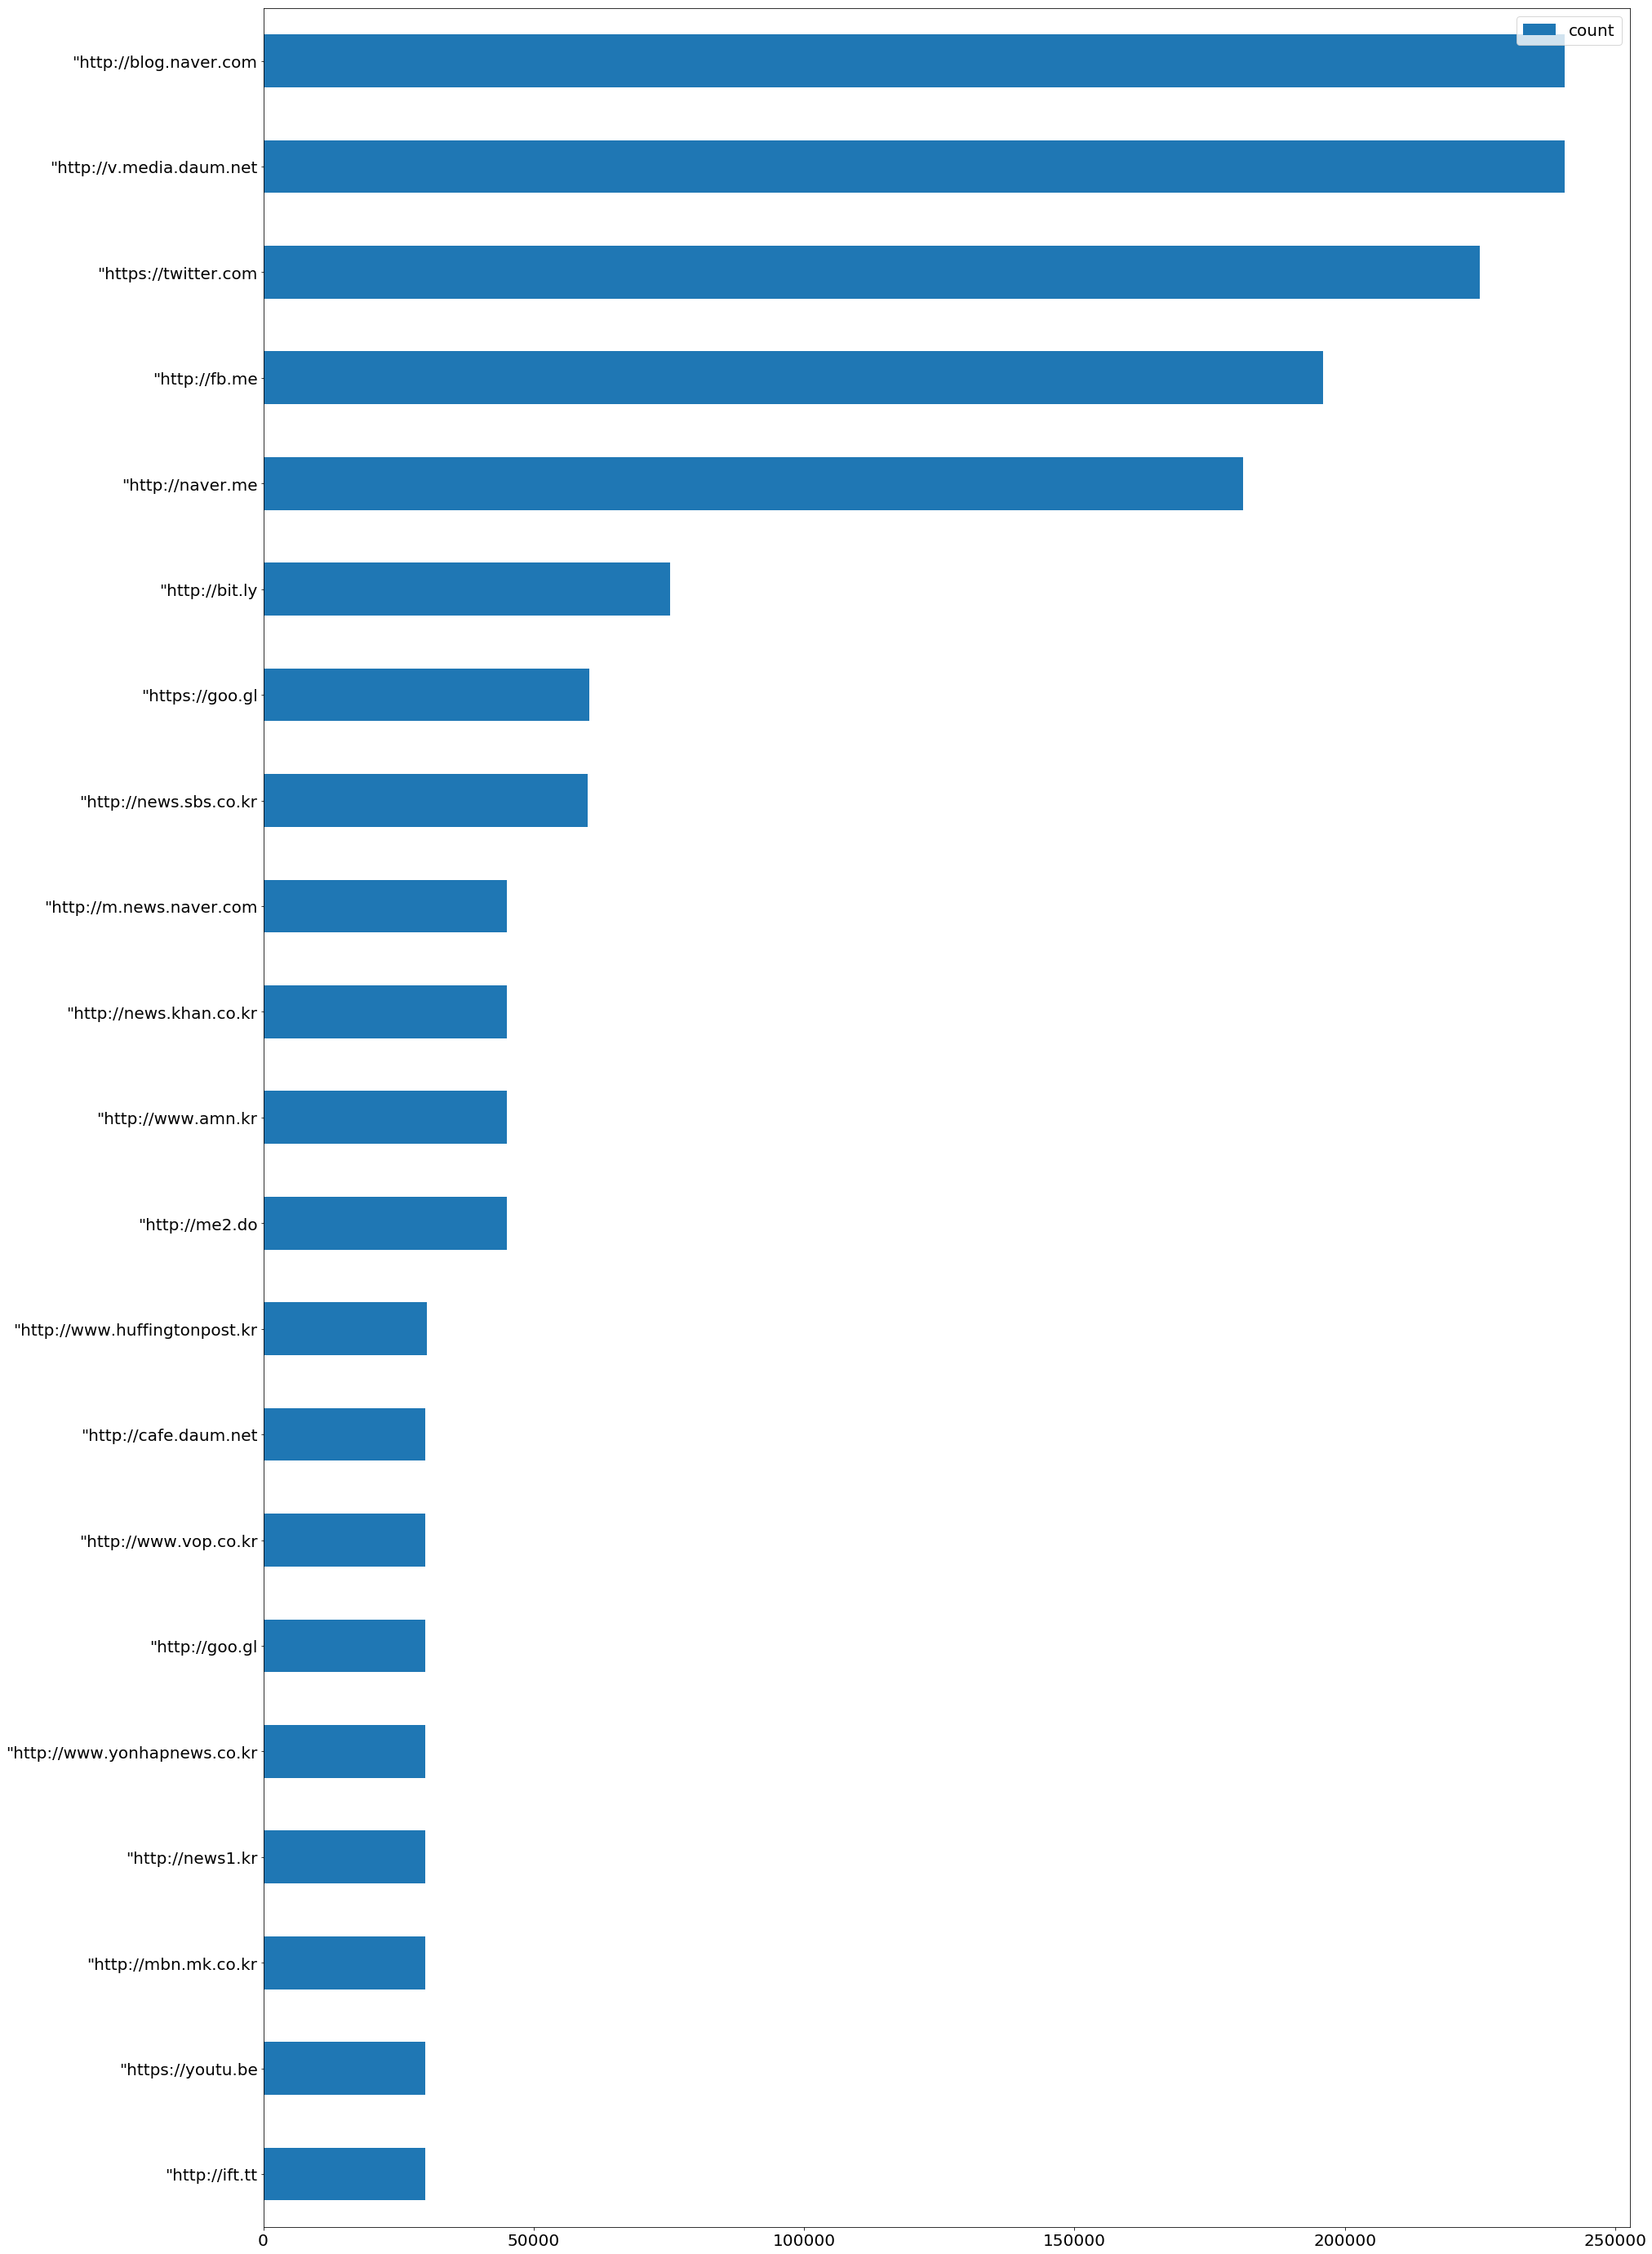

In [283]:
# Graph

# Exclude "None"

# Return Information Source with Counts Over 30,000

SourceCounterDf.head()

subset = SourceCounterDf.iloc[1:].copy()
subset2 = subset.loc[subset['count'] > 30000].copy()

xplot = subset2.sort_values(['count'], ascending = True).plot.barh(figsize=(30,50),fontsize=20)
xplot.legend(fontsize = 20, loc='upper right')

### Implication of Analysis

#### People Share Both Information from News and Social Media
My primary interest was understanding the source of information people were sharing online regarding THAAD crisis. What I found is interesting -- people do not share information from news, but more from social media outlets. Top sources include 

-  blog.naver.com,  a blog platform on Naver  
-  Twitter  
-  Facebook  
-  me2.do, a social media platform  
-  cafe.daum.net, a forum platform  
-  Youtube

However, due to their characteristics, it is unclear whether these are information written by other than the user him/herself.  

Top news sources also included news platforms run by web portals, such as  
  
-  v.media.daum.net  
-  news.naver.com

News companies in the graph includes 

-  SBS  
-  Kyunghyang Daily  
-  Voice of Seoul, an internet media
-  Huffington Post Korea  
-  Voice of People, an internet media   
-  News1  
-  Yeonhap News  
-  MBN

Also, 57.6% of the tweets collected did not include a shared link.

### Problems Understanding News Source
#### What are bit.ly?
Information source bit.ly was large at 75,303 counts, but since these links are shortened I can't understand the specific source of information shared. To get the head of original links, I retrieved the original link and extracted the head of these links to get the exact information source.

I did not have sufficient time to run the code for 75,303 bit.ly links, so in the notebook I return and visualize results for a sample of 300 bit.ly links.

In [247]:
subset.loc['"http://bit.ly','count']

75303

In [248]:
# From the Generator, Get URLs that starts with bit.ly:

generator = CsvToInfoShareDict(filename)
bitly_list = [d['url'].replace('"','') for d in generator if d['url_source'] == '"http://bit.ly']

In [249]:
len(bitly_list)

75303

In [250]:
# example 
url = bitly_list[5]
url

'http://bit.ly/2b36laC'

In [251]:
def get_bitly_heads():
    '''
    From the list of links that starts with bit.ly, extract the original link and 
    the head of the original link
    
    Parameters
    ----------
    url: a url that starts with http://bit.ly
    
    Returns
    ---------
    a head of the original url (i.e http://naver.com)
    '''
    import requests
    for url in bitly_list:
        session = requests.Session()
        resp = session.head(url, allow_redirects=True)
        the_link  = resp.url
    # get betweeen http:// and the third '/'
    href_start = "http://"
    href_start2 = "https://"
    bitly_head = []
    if href_start or href_start2 in the_link:
        if the_link.count('/') >= 3:
            i = the_link.find('/')
            the_index = the_link.index('/',i+2)
            link_head = the_link[0:the_index]
        else:
            pass
    else:
        pass
    return link_head

In [260]:
# sample of bit.ly

bitly_list_sample = bitly_list[0:200]

bitly_link_heads = []

for url in bitly_list_sample:
    bitly_link_heads.append(get_bitly_heads(url))
    
from collections import Counter
bitly_counter = dict(Counter(bitly_link_heads))

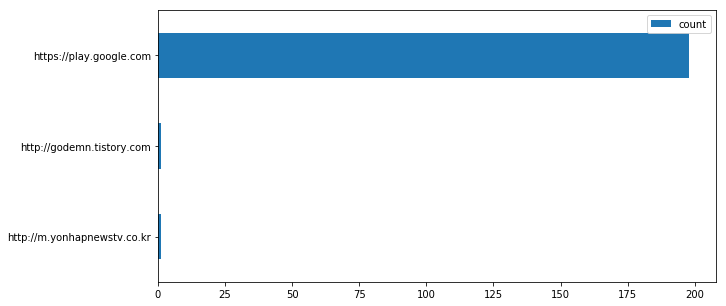

In [285]:
# Visualization
BitCounterDf = pd.DataFrame.from_dict(bitly_counter, orient='index',columns = ['count'])

lplot = BitCounterDf.sort_values(['count'], ascending = True).plot.barh(figsize=(10,5),fontsize=10)
lplot.legend(fontsize = 10, loc='upper right')

#### naver.me links

Another set of unshortened links are links that start with http://naver.me. These links are also shortened links of web portal Naver, which I found that some of them lead to news links. For instance, the unshortened version of the url in the generator result below is https://m.news.naver.com/hotissue/read.nhn?sid1=100&cid=1049580&iid=2500252&oid=001&aid=0009444264, which is a news item.

```
{'fullname': '낙준이연합전문가 친노깨비 文派작전8팀',
 'user': 'wodud2525',
 'timestamp': '2017-07-30 23:42:58',
 'url': '"http://naver.me/x3oDg83F"',
 'title': '틀딱들 아침부터 열심히 댓글다네 ㅋㅋㅋ 사드배치 안한다고 광광되더니 이제는 배치한다고 뭐라 그러네 ㅋㅋㅋ\n박근혜처럼 대북확성기 확대해야 속이 시원할라나??? ',
 'url_source': '"http://naver.me'}
```

To properly retrieve all information sources, I would need to also figure out how to unshorten these naver.me links.

#### Problems Identifying Bots
Bots on twitter may share certain news items that shares a unified political preference. Although I currently do not have intuition on how to detect bots, I think one way may be to find accounts with small number of follwers. To detect bots, I need more qualitative information and a literature review on previous attempts.

### Next Steps

#### Return all link heads for bit.ly, and also that of naver.me

Similar to bit.ly, naver.me is also a shortened link which needs to be unshortened in order to retrieve the accurate information source.

#### Word Counts of Titles of News Shared 
Since I am interested in the news shared, I will return word counts of news titles by information source (i.e official news versus social media).  